In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Importing the most popular regression libraries.
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, ridge_regression, Lasso, SGDRegressor, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score

!pip3 install tensorflow
!pip3 install keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM

# Exploratory Data Analysis

## Data Loading, Understanding and Cleaning

### Train Data Set

In [63]:
train = pd.read_csv('train.csv.zip')

This is the historical training data, which covers to 2010-02-05 to 2012-11-01. This dataset contains the following fields:

- **Store** - the store number
- **Dept** - the department number
- **Date** - the week
- **Weekly_Sales** -  sales for the given department in the given store
- **IsHoliday** - whether the week is a special holiday week

In [64]:
print('The Shape of Train dataset: ', train.shape)
train.head()

The Shape of Train dataset:  (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


### Test Data Set

In [65]:
test = pd.read_csv('test.csv.zip')

This dataset is the testing dataset that will be used to test our built model/s later.

In [66]:
print('The Shape of Test dataset: ', test.shape)
test.head()

The Shape of Test dataset:  (115064, 4)


,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


### Features Data Set

In [67]:
features = pd.read_csv('features.csv.zip')

This dataset contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:

- **Store** - the store number
- **Date** - the week
- **Temperature** - average temperature in the region
- **Fuel_Price** - cost of fuel in the region
- **MarkDown1-5** - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- **CPI** - the consumer price index
- **Unemployment** - the unemployment rate
- **IsHoliday** - whether the week is a special holiday week

For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

- **Super Bowl**: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
- **Labor Day**: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
- **Thanksgiving**: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
- **Christmas**: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

In [68]:
print('The Shape of Features dataset: ', features.shape)
features.head()

The Shape of Features dataset:  (8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### Stores Data Set

In [69]:
stores = pd.read_csv('stores.csv')

This datset contains anonymized information about the 45 stores, indicating the type and size of store.

In [70]:
print('The Shape of Stores dataset: ', stores.shape)
stores.head()

The Shape of Stores dataset:  (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


### Does Weekly Sales Vary by Different Store Types?

Let's first check the different types of stores we have in our dataset and the number of stores for each type

In [71]:
print('Types of stores: ', stores['Type'].unique())
print('\nNumber of stores for each type:')
stores['Type'].value_counts()

Types of stores:  ['A' 'B' 'C']

Number of stores for each type:


A    22
B    17
C     6
Name: Type, dtype: int64

pie-chart for the number of stores for each type

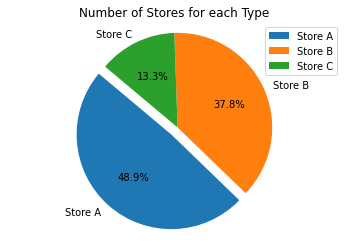

In [72]:
#pie-chart for the visual representation of store types
labels = 'Store A','Store B','Store C'
sizes = stores.Type.value_counts()
# colors = ['gold', 'yellowgreen', 'lightcoral']
explode = (0.1, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels, explode= explode, autopct='%1.1f%%', startangle=140)
plt.legend(labels, loc="best")
plt.title('Number of Stores for each Type')
plt.axis('equal')
plt.show()

It is clear that type A store is the most common type of stores in Walmart dataset followed by Type B followed by type C, which represents only 13.3% of the stores in the dataset


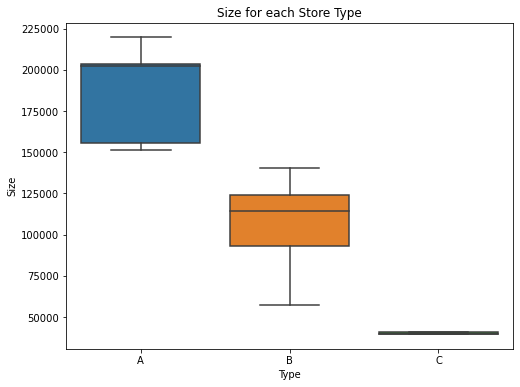

In [73]:
#Box Plot of Store Type and Store Size.
type_size = pd.concat([stores['Type'], stores['Size']], axis=1)
plt.figure(figsize=(8,6))
plt.title('Size for each Store Type')
fig = sns.boxplot(x='Type', y='Size', data=type_size, showfliers=False)

We can clearly see that Type A is the largest store in size followed by type B followed by type C, which is the smallest in size

# Data Pre-Processing

## Merging Datasets

In [74]:
train_data = train.merge(stores, how='left').merge(features, how='left')
test_data = test.merge(stores, how='left').merge(features, how='left')

In [75]:
# Checking the types of data
train_data.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

In [76]:
train_data.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
421565,45,98,2012-09-28,508.37,False,B,118221,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684
421566,45,98,2012-10-05,628.10,False,B,118221,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667
421567,45,98,2012-10-12,1061.02,False,B,118221,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667
421568,45,98,2012-10-19,760.01,False,B,118221,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667
421569,45,98,2012-10-26,1076.80,False,B,118221,58.85,3.882,4018.91,58.08,100.00,211.94,858.33,192.308899,8.667


In [77]:
# for train data - Creating date-time objects and some extra date-time fields to facilitate analysis of weekly sales by time later
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Year'] = pd.to_datetime(train_data['Date']).dt.year
train_data['Month'] = pd.to_datetime(train_data['Date']).dt.month
train_data['Week'] = pd.to_datetime(train_data['Date']).dt.week
train_data['DayOfTheMonth'] = pd.to_datetime(train_data['Date']).dt.day

In [78]:
# for test data - Creating date-time objects and some extra date-time fields to facilitate analysis of weekly sales by time later
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['Year'] = pd.to_datetime(test_data['Date']).dt.year
test_data['Month'] = pd.to_datetime(test_data['Date']).dt.month
test_data['Week'] = pd.to_datetime(test_data['Date']).dt.week
test_data['DayOfTheMonth'] = pd.to_datetime(test_data['Date']).dt.day

In [79]:
train_data.shape

(421570, 20)

In [80]:
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,DayOfTheMonth
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,2010,2,5,5
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,2010,2,6,12
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,2010,2,7,19
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,2010,2,8,26
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,2010,3,9,5


### Checking for null values

In [81]:
train_data.isna().sum()

Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday             0
Type                  0
Size                  0
Temperature           0
Fuel_Price            0
MarkDown1        270889
MarkDown2        310322
MarkDown3        284479
MarkDown4        286603
MarkDown5        270138
CPI                   0
Unemployment          0
Year                  0
Month                 0
Week                  0
DayOfTheMonth         0
dtype: int64

In [82]:
train_data.isnull().sum()

Store                 0
Dept                  0
Date                  0
Weekly_Sales          0
IsHoliday             0
Type                  0
Size                  0
Temperature           0
Fuel_Price            0
MarkDown1        270889
MarkDown2        310322
MarkDown3        284479
MarkDown4        286603
MarkDown5        270138
CPI                   0
Unemployment          0
Year                  0
Month                 0
Week                  0
DayOfTheMonth         0
dtype: int64

We will replace null and NAN values with 0

In [83]:
train_data=train_data.fillna(0)
train_data.isna().sum()

Store            0
Dept             0
Date             0
Weekly_Sales     0
IsHoliday        0
Type             0
Size             0
Temperature      0
Fuel_Price       0
MarkDown1        0
MarkDown2        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI              0
Unemployment     0
Year             0
Month            0
Week             0
DayOfTheMonth    0
dtype: int64

In [84]:
train_data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,DayOfTheMonth
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,136727.915739,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,2010.968591,6.449510,25.826762,15.673131
std,12.785297,30.492054,22711.183519,60980.583328,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,0.796876,3.243217,14.151887,8.753549
min,1.000000,1.000000,-4988.940000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,2010.000000,1.000000,1.000000,1.000000
25%,11.000000,18.000000,2079.650000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2010.000000,4.000000,14.000000,8.000000
50%,22.000000,37.000000,7612.030000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,2011.000000,6.000000,26.000000,16.000000
75%,33.000000,74.000000,20205.852500,202505.000000,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,2012.000000,9.000000,38.000000,23.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,52.000000,31.000000


From the dataframe statistics, we can see that there are some rows where Weekly sales have negative values. Since sales values can’t be negative, rows having negative weekly sales will be dropped.

In [85]:
train_data = train_data[train_data['Weekly_Sales']>=0]

In [86]:
train_data.describe()

,Store,Dept,Weekly_Sales,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Week,DayOfTheMonth
count,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000,420285.000000
mean,22.195477,44.242771,16030.329773,136749.569176,60.090474,3.360888,2590.187246,878.803239,468.771234,1083.462694,1662.706138,171.212152,7.960077,2010.968443,6.449709,25.827729,15.673919
std,12.787213,30.507197,22728.500149,60992.688568,18.448260,0.458523,6053.225499,5076.525234,5533.593112,3895.801513,4205.946641,39.162280,1.863873,0.796893,3.243394,14.152442,8.752825
min,1.000000,1.000000,0.000000,34875.000000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,2010.000000,1.000000,1.000000,1.000000
25%,11.000000,18.000000,2117.560000,93638.000000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,2010.000000,4.000000,14.000000,8.000000
50%,22.000000,37.000000,7659.090000,140167.000000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,2011.000000,6.000000,26.000000,16.000000
75%,33.000000,74.000000,20268.380000,202505.000000,74.280000,3.738000,2801.500000,2.400000,4.540000,425.290000,2168.040000,212.445487,8.567000,2012.000000,9.000000,38.000000,23.000000
max,45.000000,99.000000,693099.360000,219622.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,2012.000000,12.000000,52.000000,31.000000


In [87]:
train_data.to_csv('walmart_df.csv')

## Correlation Matrix

### Check for the existance of correlated features in the dataset

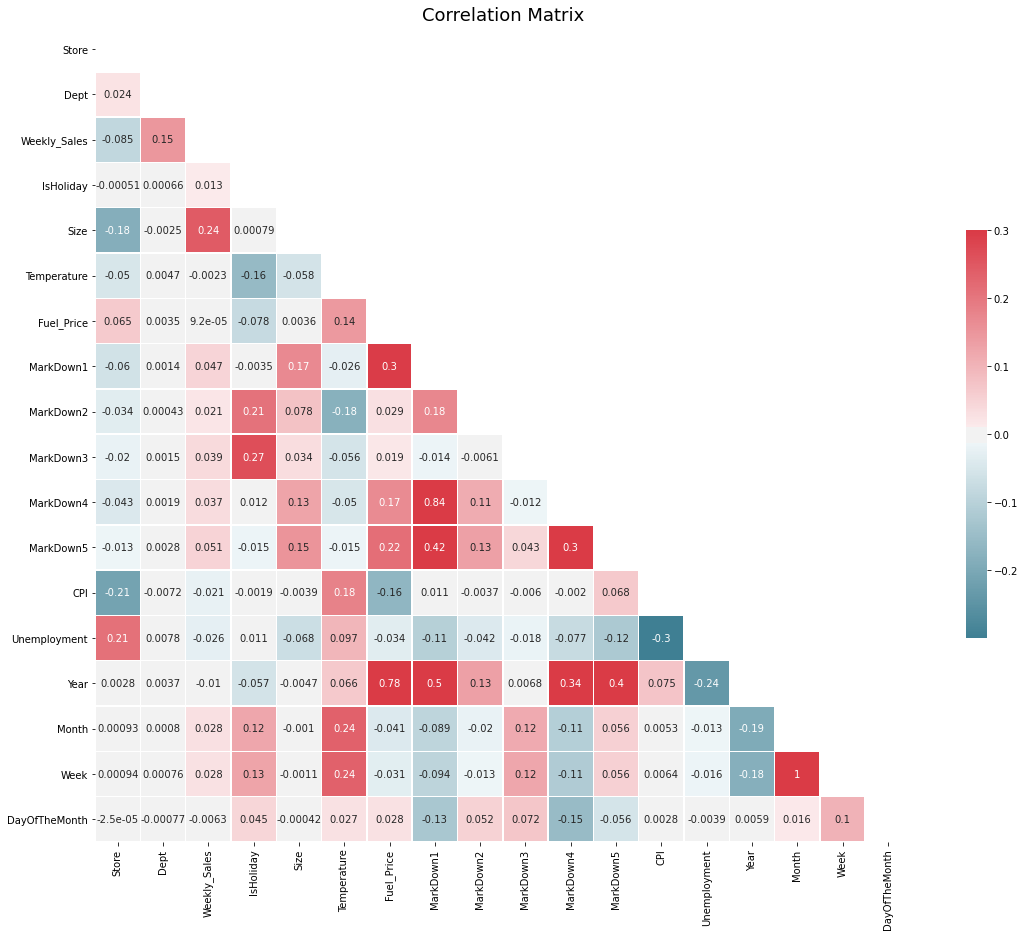

In [26]:

corr = train_data.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Dealing with categorical features (type, IsHoliday)
Use One Hot Encoding to encode categorical variable (type)

In [27]:
train_data = pd.get_dummies(train_data, columns=["Type"])
test_data = pd.get_dummies(test_data, columns=["Type"])
train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Year,Month,Week,DayOfTheMonth,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,False,151315,42.31,2.572,0.0,0.0,...,0.0,211.096358,8.106,2010,2,5,5,1,0,0
1,1,1,2010-02-12,46039.49,True,151315,38.51,2.548,0.0,0.0,...,0.0,211.242170,8.106,2010,2,6,12,1,0,0
2,1,1,2010-02-19,41595.55,False,151315,39.93,2.514,0.0,0.0,...,0.0,211.289143,8.106,2010,2,7,19,1,0,0
3,1,1,2010-02-26,19403.54,False,151315,46.63,2.561,0.0,0.0,...,0.0,211.319643,8.106,2010,2,8,26,1,0,0
4,1,1,2010-03-05,21827.90,False,151315,46.50,2.625,0.0,0.0,...,0.0,211.350143,8.106,2010,3,9,5,1,0,0


In [28]:
# Converting Categorical Variable 'IsHoliday' into Numerical Variables.
type_mapping = {False: 0, True: 1}
train_data['IsHoliday'] = train_data['IsHoliday'].map(type_mapping)

train_data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,MarkDown5,CPI,Unemployment,Year,Month,Week,DayOfTheMonth,Type_A,Type_B,Type_C
0,1,1,2010-02-05,24924.50,0,151315,42.31,2.572,0.0,0.0,...,0.0,211.096358,8.106,2010,2,5,5,1,0,0
1,1,1,2010-02-12,46039.49,1,151315,38.51,2.548,0.0,0.0,...,0.0,211.242170,8.106,2010,2,6,12,1,0,0
2,1,1,2010-02-19,41595.55,0,151315,39.93,2.514,0.0,0.0,...,0.0,211.289143,8.106,2010,2,7,19,1,0,0
3,1,1,2010-02-26,19403.54,0,151315,46.63,2.561,0.0,0.0,...,0.0,211.319643,8.106,2010,2,8,26,1,0,0
4,1,1,2010-03-05,21827.90,0,151315,46.50,2.625,0.0,0.0,...,0.0,211.350143,8.106,2010,3,9,5,1,0,0


## Splitting Data into 2 Parts - Train and Test

In [29]:
# Sort data in increasing order of Date before splitting
train_df = train_data.sort_values(by='Date', ascending=True) 

# Remove Date column as it does not allow the models to fit on the data 
train_df = train_df.drop(['Date'], axis=1)

# Split
y = train_df['Weekly_Sales']
X = train_df.drop(['Weekly_Sales'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

## Defining the Performance metric

In [30]:
"""Define Performance metric - Weighted Mean Absolute Error (WMAE)"""

def wmae_train(test, pred): # WMAE for train
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error  

def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

## Machine Learning Models

We will use and compare the performance of the following regression models:

- Linear Regression
- K Nearest Neighbors Regression
- Ridge Regression
- Lasso Regression
- Decision Tree Regression
- Random Forest Regression
- ExtraTrees Regression
- XGBoost Regression


For every regression model of the above, we will perform the following steps:

1. Define the parameters that each model takes
2. Fit the model on training data
3. Fine tune the parameters using GridSearch/RandomSearch technique
4. Retrain the model on tuned paramteres
5. Predict the weekly sales for test data
6. Get the accuracy using score function

And finally we will compare the performance of various models used.

### 1. Linear Regression

In [31]:
# Fit the model.
linear_reg = LinearRegression(fit_intercept=True,normalize=True).fit(X_train,y_train)
# Predict test data.
y_pred = linear_reg.predict(X_test) 
# Calculate WMAE score.
print('Weighted Mean Absolute Error (WMAE) for Linear Regression:', wmae_test(y_test, y_pred)) 

training_score = cross_val_score(linear_reg, X_train, y_train, cv=5)
print("Linear Regresson Model Accuracy: ", round(training_score.mean(), 2) * 100, "%")

Weighted Mean Absolute Error (WMAE) for Linear Regression: 14832.740896432324
Linear Regresson Model Accuracy:  9.0 %


In [32]:
def regression_model(model, param, X_train,y_train, X_test, model_name):
    grid_cv_model = GridSearchCV(model, param, cv=3, 
                   n_jobs=-1, verbose=1)

    
    grid_cv_model.fit(X_train,y_train)
    
    best_model = grid_cv_model.best_estimator_
    check_performance(best_model, X_train,y_train, X_test, model_name)

In [46]:
def check_performance(model, X_train,y_train, X_test, model_name):
    # Predict test data.
    y_pred = model.predict(X_test)
    
    # Calculate WMAE score
    wmae_test(y_test, y_pred)
    # Calculate Accuracy
    training_score = cross_val_score(model, X_train, y_train, cv=5)
    accuracy = round(training_score.mean(), 4) * 100
    print('Weighted Mean Absolute Error (WMAE) for ', model_name, ':', wmae_test(y_test, y_pred)) 
    print(model_name, ' Model Accuracy: ', accuracy, '%')

### 2. Decision Tree Regression

In [34]:
# Using GridSearchCV to fine tune hyperparameters
param_grid = {
              "min_samples_split": [10, 20, 40],
              "max_depth": [1,5,35],
              "min_samples_leaf": [1,5,20, 40]
              }

regression_model(DecisionTreeRegressor(), param_grid, X_train,y_train, X_test, 'Decison Tree Regressor')

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   17.7s finished


Weighted Mean Absolute Error (WMAE) for  Decison Tree Regressor : 2115.824731901214
Decison Tree Regressor  Model Accuracy:  95.0 %


The same process could be applied using GridSearchCV or other hyperparameter tuning methods to fine tune the parameters; However, due to tight timeframe for this project, we will skip this process for the rest of the regression models used!

### 3. Random Forest Regression

In [47]:
model_rf = RandomForestRegressor(n_estimators=50)
model_rf.fit(X_train, y_train)
check_performance(model_rf, X_train,y_train, X_test, 'Random Forest Regression')

Weighted Mean Absolute Error (WMAE) for  Random Forest Regression : 1718.665619586966
Random Forest Regression  Model Accuracy:  96.89999999999999 %


### 4. XGBoost Regression

In [48]:
# Using GridSearchCV to fine tune hyperparameters
# A parameter grid for XGBoost
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
model_xgb = XGBRegressor(n_estimators=20, max_depth=15)
model_xgb.fit(X_train,y_train)
check_performance(model_xgb, X_train,y_train, X_test, 'XGBoost Regression')

Weighted Mean Absolute Error (WMAE) for  XGBoost Regression : 1643.807027061568
XGBoost Regression  Model Accuracy:  97.24000000000001 %


## LSTM - Long-Short Term Memory

In [ ]:
reshaped_X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
reshaped_X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

# Build LSTM
model = Sequential()
model.add(LSTM(4, batch_input_shape=(1, reshaped_X_train.shape[1], reshaped_X_train.shape[2]), stateful=True))
model.add(Dense(1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(reshaped_X_train, y_train, epochs=10, batch_size=1, verbose=1, shuffle=False)
predictions = model.predict(reshaped_X_test, batch_size=1)